# For this notebook, we've saved many of the analyses from past notebooks, and are mostly iterating on the aesthetics of the figures

In [1]:
import matplotlib
matplotlib.use('Agg')

import numpy as np
import collections
from functools import partial
from os.path import expanduser
from tqdm import tqdm
import h5py

from surround.image_processing import *
from surround.data_handling import *
from surround.efficient_coding import *
from aesthetics.plotting import *
from surround.modeling import gaussian, difference_of_gaussians

import pyret.filtertools as ft
from sklearn.decomposition import PCA
from scipy.stats import sem
from scipy.optimize import curve_fit, minimize
from scipy.interpolate import interp1d
from scipy.stats import pearsonr

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

plt.style.use('deepretina')

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

You must install GPy (pip install GPy) to fit the GP regression nonlinearity.


In [2]:
microns_per_degree = 50.0 # depends on species; this is for salamander
photoreceptor_width = 10.0/microns_per_degree # salamander photoreceptors have width of 10-20 microns
retina_width = 4000.0/microns_per_degree # salamander retina is about 4 mm
frequency_spacing = 1./retina_width # this is the lowest non-DC frequency we can estimate
highest_frequency = 0.5/photoreceptor_width # this is the highest frequency we can estimate (Nyquist freq.)

N = retina_width//photoreceptor_width
freqs = np.linspace(0, highest_frequency, N//2 + 1)
space = np.concatenate([np.linspace(-0.5*retina_width, 0, N//2 + 1)[:-1], np.linspace(0, 0.5*retina_width, N//2 + 1)])

### Load receptive fields

In [3]:
# These are loaded as (space, receptive) field tuples
cells = {}
cells['ganglion'] = load_ganglion_cells(space_mode='peak')
cells['bipolar'] = load_bipolar_cells(space_mode='peak')
cells['amacrine'] = load_amacrine_cells(space_mode='peak')
cells['horizontal'] = load_horizontal_cells(space_mode='peak')

In [4]:
receptive_fields = collections.defaultdict(list)
for c in cells.keys():
    for s, rf in cells[c]:
        this_cell_interp = interp1d(s, rf, kind='slinear', bounds_error=False, fill_value=[0])
        receptive_fields[c].append(this_cell_interp(space))
        
average_ganglion_rf = np.mean(receptive_fields['ganglion'], axis=0)

David's 1721 receptive field dataset

In [5]:
data_path = expanduser('~/data/kastner/receptive_fields/')
spatialDelta = 0.05 # mm
micronsPerDeg = 50.
ganglion_rfs = {
    'fast_on': np.loadtxt(data_path + 'linesRF1.txt').reshape((126, 101, -1)),
    'fast_off_adapting': np.loadtxt(data_path + 'linesRF19.txt').reshape((-1, 101, 96)),
    'fast_off_sensitizing': np.loadtxt(data_path + 'linesRF8.txt').reshape((-1, 101, 96)),
    'medium_off_adapting': np.loadtxt(data_path + 'linesRF29.txt').reshape((-1, 101, 96)),
    'slow_off': np.loadtxt(data_path + 'linesRF17.txt').reshape((-1, 101, 96)),
}

for celltype in ganglion_rfs.keys():
    for rf in ganglion_rfs[celltype]:
        # since receptive fields are noisy, use PCA
        pca = PCA(n_components=2)
        pca.fit(rf)
        g_pca = pca.components_[0]

        sign_of_pc = -1 * np.sign(g_pca[abs(g_pca) == np.max(abs(g_pca))])
        this_space = get_space(g_pca, spatialDelta, micronsPerDeg, kind='peak')
        
        rf_interp = interp1d(this_space, sign_of_pc*g_pca, kind='slinear', bounds_error=False, fill_value=[0])

        receptive_fields[celltype].append(rf_interp(space))

### Remove duplicates

In [6]:
corr_map = {}
for celltype in receptive_fields.keys():
    corr_map[celltype] = np.zeros((len(receptive_fields[celltype]), len(receptive_fields[celltype])))
    for idr1, rf1 in tqdm(enumerate(receptive_fields[celltype])):
        for idr2 in range(idr1+1, len(receptive_fields[celltype])):
            rf2 = receptive_fields[celltype][idr2]
            corr_map[celltype][idr1, idr2] = pearsonr(rf1, rf2)[0]

unduplicated_receptive_fields = collections.defaultdict(list)
duplicates = collections.defaultdict(list)

for celltype in corr_map.keys():
    these_dups = []
    for row in corr_map[celltype]:
        these_dups.append([i for i in range(len(row)) if row[i] == 1.0])
    duplicates[celltype] = np.unique(np.hstack(these_dups))
    
unduplicated_receptive_fields = collections.defaultdict(list)
for celltype in receptive_fields.keys():
    for idr, rf in enumerate(receptive_fields[celltype]):
        if idr not in duplicates[celltype]:
            unduplicated_receptive_fields[celltype].append(rf)
            
receptive_fields = unduplicated_receptive_fields.copy()
del unduplicated_receptive_fields

In [7]:
sum([len(receptive_fields[k]) for k in receptive_fields.keys()]) - sum([len(receptive_fields[k]) for k in ['horizontal',
                                                                                                           'amacrine',
                                                                                                          'bipolar']])

1382

### Compute projective fields

In [8]:
horz_pfs_full = get_horizontal_projective_field(conv_mode='full')
horz_pfs_same = get_horizontal_projective_field(conv_mode='same')
ama_pfs_full = get_amacrine_projective_field(conv_mode='full')
ama_pfs_same = get_amacrine_projective_field(conv_mode='same')

space_h_full, horz_pf_full, horz_sem_full = get_mean(horz_pfs_full)
space_h_same, horz_pf_same, horz_sem_same = get_mean(horz_pfs_same)
space_a_full, ama_pf_full, ama_sem_full = get_mean(ama_pfs_full)
space_a_same, ama_pf_same, ama_sem_same = get_mean(ama_pfs_same)

In [9]:
horz_pf_interp = interp1d(space_h_full, horz_pf_full, kind='slinear', bounds_error=False, fill_value=[0])
ama_pf_interp = interp1d(space_a_full, ama_pf_full, kind='slinear', bounds_error=False, fill_value=[0])

horz_pf = horz_pf_interp(space)
ama_pf = ama_pf_interp(space)

### Signal

In [10]:
# choose an image path from cd13A (flood plain, water, horizon) or cd01A (baboons, trees, bushes)
pixelsToDeg = 92./2 # or 2./92 degrees per pixel (spacing)
spacing = 1./pixelsToDeg # number of degree spacing between pixels
normalize = 'divisive'
contrast = 0.35
signal = np.array(np.load('signal_3_23.npy'))

### Noise  
Note that the amplitude of the average_ganglion_fft will change the SNR. As the amplitude $\rightarrow \infty$, we get $$\rm{SNR} \rightarrow \frac{\sum (\rm{filter}_{1:f} \times \rm{signal}_{1:f})^2}{\sum (\rm{filter}_{1:f} \times N_{\rm{in}})^2}$$.  

Since the scale of the ganglion fft is arbitrary, we can look at the SNR in this limit.

In [11]:
input_noise = 0.098762200628786892
output_noise = 0.35
target_power = 54.131410989171826

1.92576130327


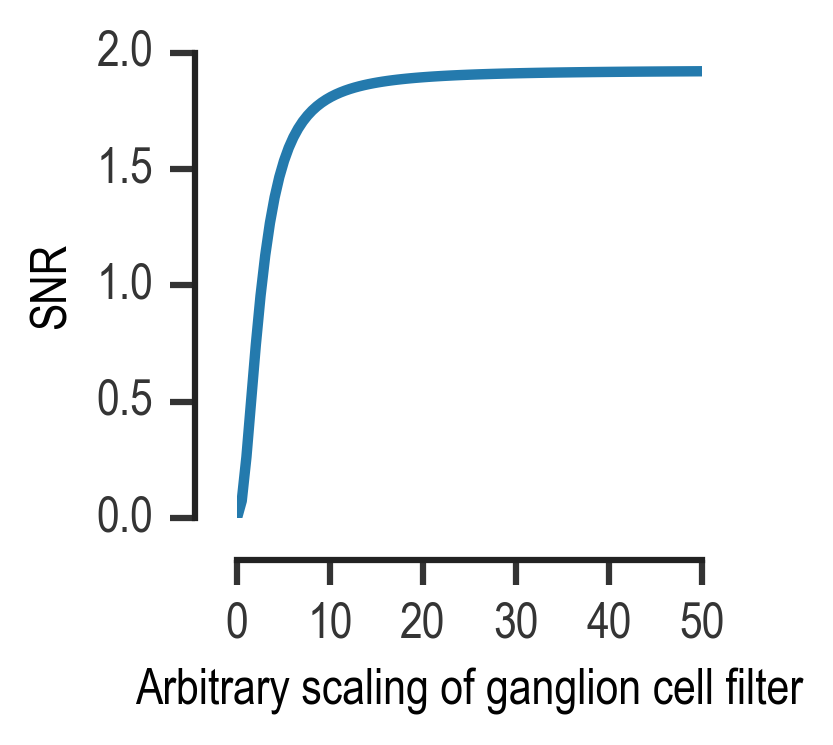

In [12]:
fig = plt.gcf()
fig.set_size_inches((2,2))
average_ganglion_fft = abs(np.fft.rfft(average_ganglion_rf))
print(get_snr(input_noise, output_noise, signal, 1000*average_ganglion_fft, mode='variance'))
snrs = [get_snr(input_noise, output_noise, signal, c*average_ganglion_fft) for c in np.linspace(0,50,100)]
plt.plot(np.linspace(0,50,100), snrs)
adjust_spines(plt.gca())
plt.xlabel('Arbitrary scaling of ganglion cell filter')
plt.ylabel('SNR')

In [13]:
# SNR = 0.269 is total SNR from ganglion recordings of 112 repeats to 30 seconds natural scenes
def find_filt_const(filt_const):
    this_snr = get_snr(input_noise, output_noise, signal, filt_const*average_ganglion_fft, mode='variance')
    return (this_snr - 0.26912469)**2

filt_const_opt = scipy.optimize.minimize_scalar(find_filt_const)

print(get_snr(input_noise, output_noise, signal, filt_const_opt.x*average_ganglion_fft, mode='variance'))

0.269124689452


1.92576130327


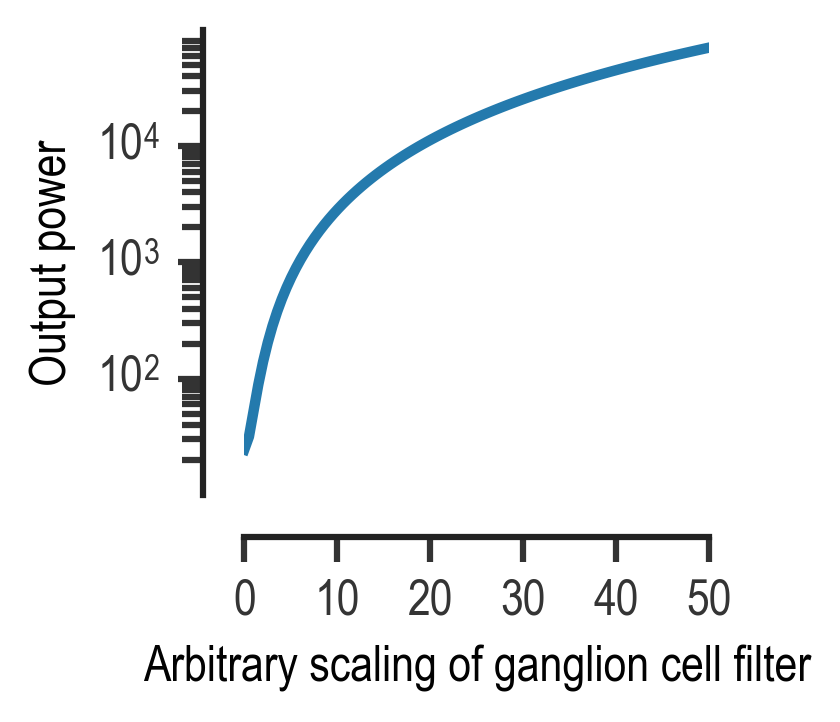

In [14]:
fig = plt.gcf()
fig.set_size_inches((2,2))
average_ganglion_fft = abs(np.fft.rfft(average_ganglion_rf))
print(get_snr(input_noise, output_noise, signal, 1000*average_ganglion_fft, mode='variance'))

def output_power(filt_const, signal, rf_filt, input_noise, output_noise):
    # return power from signal and rf_filt in frequency space
    power = np.sum((signal*filt_const*rf_filt)**2 + (input_noise*filt_const*rf_filt)**2 + output_noise**2)
    return power

filt_constants = np.linspace(0,50,100)
powers = [output_power(c, signal, average_ganglion_fft, input_noise, output_noise) for c in filt_constants]
snrs = [get_snr(input_noise, output_noise, signal, c*average_ganglion_fft) for c in filt_constants]

plt.plot(filt_constants, powers)
# plt.plot(filt_constants, snrs)
adjust_spines(plt.gca())
plt.xlabel('Arbitrary scaling of ganglion cell filter')
# plt.ylabel('SNR')
plt.ylabel('Output power')
plt.yscale('log')

### Ideal filter

In [15]:
ideal_filter = unique_soln(signal**2, input_noise, output_noise)

The relative error from this choice of Lagrangian multiplier is 1.41193781619e-07.


### Model of Horizontal Projective Field + Amacrine Projective Field + Center

In [16]:
horz_pf /= np.sum(horz_pf)
ama_pf /= np.sum(ama_pf)

### Just a simple difference of Gaussians fit to get the initialization point for center width, and the mean center width to find the ideal fit

Get center widths for each celltype

In [17]:
diff_of_gauss_mu0 = partial(difference_of_gaussians, mu=0)

In [18]:
def center_and_surround(space, center_width, surround_width, center_strength, surround_strength):
    return diff_of_gauss_mu0(space, abs(center_width), abs(surround_width),
                            -abs(center_strength), abs(surround_strength))

In [19]:
center_widths = collections.defaultdict(list)
surround_widths = collections.defaultdict(list)
center_strengths = collections.defaultdict(list)
surround_strengths = collections.defaultdict(list)
fit_failures = collections.defaultdict(list)

for celltype in receptive_fields.keys():
    if celltype in ['ganglion', 'fast_on', 'fast_off_adapting', 'fast_off_sensitizing', 
                    'medium_off_adapting', 'slow_off']:
        
        for idg, g in tqdm(enumerate(receptive_fields[celltype])):
            try:
                popt_this, pcov = curve_fit(center_and_surround, space, g, p0=[1.5, 3.5, -10, 30])
                center_id = np.argmin(abs(popt_this[:2]))
                surround_id = 1 ^ center_id
                center_widths[celltype].append(abs(popt_this[center_id]))
                surround_widths[celltype].append(abs(popt_this[surround_id]))
                center_strengths[celltype].append(popt_this[center_id+2])
                surround_strengths[celltype].append(popt_this[surround_id+2])
#                 plt.plot(space, diff_of_gauss_mu0(space, *popt_this), color=np.random.rand(3), alpha=0.6)
            except:
                fit_failures[celltype].append(idg)
            
                # just set params to median across cells
                # this way the params are still aligned with the receptive field id
                center_widths[celltype].append(np.median(center_widths[celltype]))
                surround_widths[celltype].append(np.median(surround_widths[celltype]))
                center_strengths[celltype].append(np.median(center_strengths[celltype]))
                surround_strengths[celltype].append(np.median(surround_strengths[celltype]))
                
#                 print("Couldn't fit cell %d" %idg)

In [20]:
for f in fit_failures.keys():
    print("couldn't fit %d in %s" %(len(fit_failures[f]), f))

couldn't fit 4 in fast_off_adapting
couldn't fit 3 in fast_off_sensitizing
couldn't fit 3 in medium_off_adapting
couldn't fit 1 in fast_on
couldn't fit 3 in ganglion
couldn't fit 12 in slow_off


Plot the average profile across celltypes

In [21]:
median_center_widths = {}
for celltype in center_widths.keys():
    cws = np.array(center_widths[celltype])
    sws = np.array(surround_widths[celltype])
    css = np.array(center_strengths[celltype])
    sss = np.array(surround_strengths[celltype])
#     mean_center_widths[celltype] = np.mean(cws[cws < 500])
#     mean_surround_width = np.mean(sws[sws < 500])
#     mean_center_strength = np.mean(css[abs(css) < 500])
#     mean_surround_strength = np.mean(sss[abs(sss) < 500])
    
    median_center_widths[celltype] = np.median(abs(cws))
    median_surround_width = np.median(abs(sws))
    median_center_strength = np.median(-abs(css))
    median_surround_strength = np.median(abs(sss))
#     plt.plot(space, diff_of_gauss_mu0(space, median_center_widths[celltype], median_surround_width,
#                                      median_center_strength, median_surround_strength), label=celltype)
# plt.legend(frameon=False, fontsize=9, loc='lower left')
# adjust_spines(plt.gca())

In [22]:
median_center_widths

{'fast_off_adapting': 1.6921005222097691,
 'fast_off_sensitizing': 2.0453564228835579,
 'fast_on': 2.1703662984878926,
 'ganglion': 1.3731414004097489,
 'medium_off_adapting': 1.5618970887682422,
 'slow_off': 1.5252284316234648}

## Look at the distribution of SNRs and filter weights for all RFs

In [33]:
resolution = 150
horz_weights = np.linspace(0,1,resolution)
center_weights = np.linspace(0,1,resolution)
init_filt_const = 10.9

all_snrs = collections.defaultdict(list)
all_filter_consts = collections.defaultdict(list)

for celltype in receptive_fields.keys():
    if celltype in ['ganglion', 'fast_on', 'fast_off_adapting', 'fast_off_sensitizing', 
                    'medium_off_adapting', 'slow_off']:
        center = gaussian(x=space, sigma=median_center_widths[celltype], mu=0.)
        center /= -np.sum(center) # make center unit vector like horz_pf and ama_pf
        
        def rf_model(horz_weight, center_weight):
            return center_weight*center + (1-center_weight)*(horz_weight*horz_pf + (1-horz_weight)*ama_pf)
        
#         print('Information map for %s cells.' %celltype)
        
        infomap = np.zeros((resolution, resolution))
        for idh,hw in tqdm(enumerate(horz_weights)):
            for idc,cw in enumerate(center_weights):
                rf = rf_model(hw, cw)
                rf_filt = abs(np.fft.rfft(rf))
                
                # constrain model
                def constrain_filt_power(filt_const):
                    size = len(rf_filt)
                    output_power = np.sum((signal*filt_const*rf_filt)**2 
                                          + (input_noise*filt_const*rf_filt)**2
                                          + output_noise**2)
                    
                    return (target_power - output_power)**2

                filt_const_opt = scipy.optimize.minimize(constrain_filt_power, init_filt_const)
                iterations = 0
                new_init_filt_const = init_filt_const
                while not filt_const_opt.success:
                    iterations += 1
                    new_init_filt_const *= 10
                    filt_const_opt = scipy.optimize.minimize(constrain_filt_power, new_init_filt_const)
                    if iterations > 10:
                        detailed_failures[celltype] = filt_const_opt
                        break
                
                filt_const = abs(filt_const_opt['x'])
                all_filter_consts[celltype].append(filt_const[0])
                
                if not filt_const_opt.success:
                    failures[celltype].append([hw, cw])

                signal_power = (filt_const * rf_filt * signal)**2
                noise_power = (filt_const * rf_filt * input_noise)**2 + output_noise**2
#                 infomap[idh,idc] = 0.5*np.sum(np.log2(1 + signal_power/noise_power))
                all_snrs[celltype].append(get_snr(input_noise, output_noise, signal, filt_const*rf_filt,
                                                 mode='variance'))

In [34]:
len(all_snrs['fast_off_adapting'])

22500

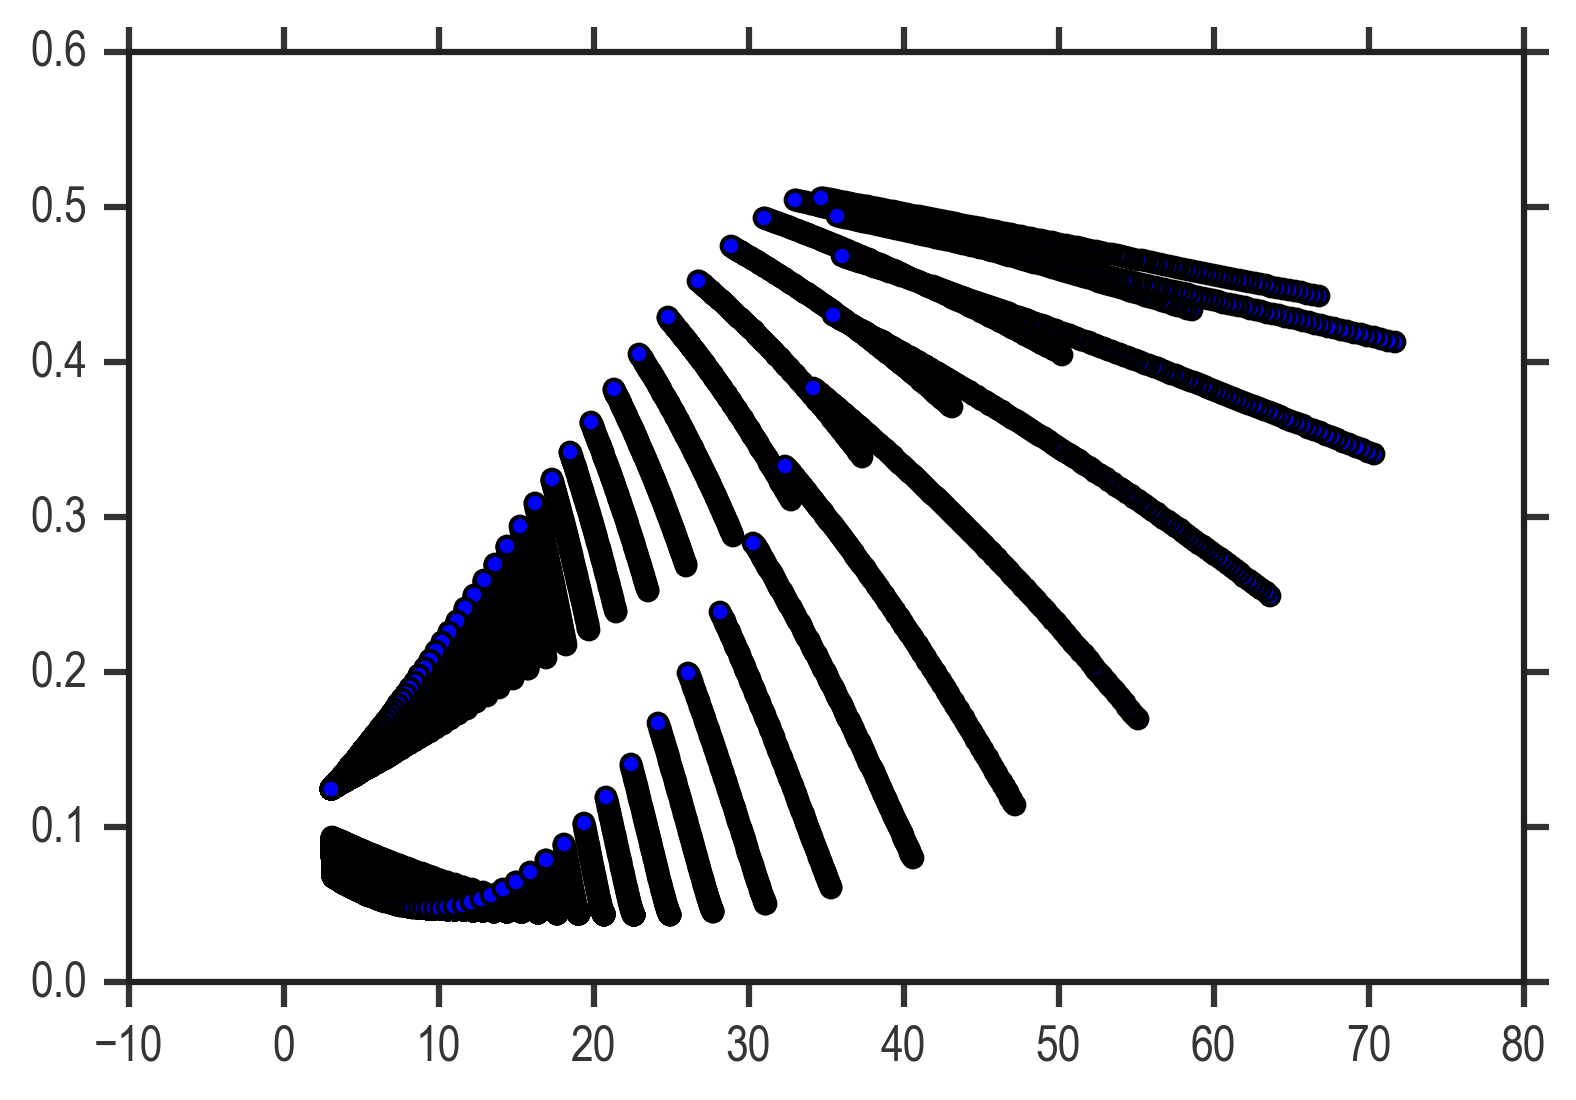

In [36]:
plt.scatter(all_filter_consts['fast_off_adapting'], all_snrs['fast_off_adapting'])

## How do changes in input/output/power affect info maps?

Since the maps are basically constant across hw axis, just pick hw=0.5.

In [43]:
colorscheme = {
    'ganglion': 'k',
    'fast_off_sensitizing': 'r',
    'fast_off_adapting': 'g',
    'slow_off': 'y',
    'fast_on': 'b',
    'medium_off_adapting': 'c'
}

In [48]:
input_noise

0.09876220062878689

In [49]:
output_noise

0.35

In [50]:
target_power

54.131410989171826

In [72]:
np.logspace(-2,0.5,5)

array([ 0.01      ,  0.04216965,  0.17782794,  0.74989421,  3.16227766])

In [92]:
resolution = 150
horz_weights = [0.5]
center_weights = np.linspace(0,1,resolution)

celltype = 'fast_on'
init_filt_const = 10.9
info_maps = collections.defaultdict(list) # one info map per celltype (since they will be a function of center width)
failures = collections.defaultdict(list)
detailed_failures = collections.defaultdict(list)


input_noises = np.array([np.float('%0.2f' %x) for x in np.logspace(-2,0.5,5)])
output_noises = np.array([np.float('%0.2f' %x) for x in np.logspace(-2,0.5,5)])
powers = np.round(np.linspace(1.,200,4))
for input_noise in tqdm(input_noises):
    for output_noise in output_noises:
        for target_power in powers:
            center = gaussian(x=space, sigma=median_center_widths[celltype], mu=0.)
            center /= -np.sum(center) # make center unit vector like horz_pf and ama_pf

            def rf_model(horz_weight, center_weight):
                return center_weight*center + (1-center_weight)*(horz_weight*horz_pf + (1-horz_weight)*ama_pf)

    #         print('Information map for %s cells.' %celltype)

            infomap = np.zeros((resolution,))
            hw = horz_weights[0]
            for idc,cw in enumerate(center_weights):
                rf = rf_model(hw, cw)
                rf_filt = abs(np.fft.rfft(rf))

                # constrain model
                def constrain_filt_power(filt_const):
                    size = len(rf_filt)
                    output_power = np.sum((signal*filt_const*rf_filt)**2 
                                          + (input_noise*filt_const*rf_filt)**2
                                          + output_noise**2)

                    return (target_power - output_power)**2

                filt_const_opt = scipy.optimize.minimize(constrain_filt_power, init_filt_const)
                iterations = 0
                new_init_filt_const = init_filt_const
                while not filt_const_opt.success:
                    iterations += 1
                    new_init_filt_const *= 10
                    filt_const_opt = scipy.optimize.minimize(constrain_filt_power, new_init_filt_const)
                    if iterations > 10:
                        detailed_failures[celltype] = filt_const_opt
                        break

                filt_const = abs(filt_const_opt['x'])

                if not filt_const_opt.success:
                    failures[celltype].append([hw, cw])

                signal_power = (filt_const * rf_filt * signal)**2
                noise_power = (filt_const * rf_filt * input_noise)**2 + output_noise**2
                infomap[idc] = 0.5*np.sum(np.log2(1 + signal_power/noise_power))
            info_maps['%0.2f, %0.2f, %0.2f' %(input_noise, output_noise, target_power)] = infomap

In [93]:
list(info_maps.keys())

['0.18, 3.16, 134.00',
 '0.04, 0.01, 67.00',
 '0.01, 3.16, 1.00',
 '0.18, 0.04, 67.00',
 '0.75, 3.16, 1.00',
 '3.16, 0.04, 134.00',
 '0.75, 0.01, 67.00',
 '3.16, 0.75, 67.00',
 '3.16, 3.16, 67.00',
 '0.04, 0.75, 134.00',
 '3.16, 0.18, 134.00',
 '0.01, 3.16, 134.00',
 '0.18, 0.04, 1.00',
 '3.16, 0.04, 200.00',
 '0.18, 3.16, 67.00',
 '0.18, 0.75, 200.00',
 '0.75, 3.16, 134.00',
 '0.75, 0.01, 1.00',
 '0.04, 0.01, 134.00',
 '0.04, 0.18, 134.00',
 '0.75, 0.04, 67.00',
 '0.04, 0.75, 67.00',
 '0.18, 3.16, 200.00',
 '3.16, 0.75, 200.00',
 '0.01, 0.01, 1.00',
 '0.04, 0.18, 200.00',
 '0.18, 0.75, 134.00',
 '0.18, 0.18, 200.00',
 '3.16, 0.75, 134.00',
 '0.75, 0.18, 67.00',
 '0.04, 0.01, 200.00',
 '0.75, 0.75, 134.00',
 '3.16, 0.01, 200.00',
 '0.04, 0.01, 1.00',
 '3.16, 0.75, 1.00',
 '0.04, 0.75, 1.00',
 '0.18, 0.18, 67.00',
 '3.16, 0.18, 67.00',
 '0.04, 3.16, 67.00',
 '3.16, 0.18, 1.00',
 '0.04, 0.04, 67.00',
 '0.04, 0.04, 134.00',
 '0.01, 0.04, 134.00',
 '0.75, 0.04, 1.00',
 '0.18, 0.75, 1.00',


0.75, 0.18, 67.00, optimal cw = 0.85
0.75, 0.04, 1.00, optimal cw = 1.00
0.75, 0.75, 200.00, optimal cw = 1.00
0.75, 0.18, 200.00, optimal cw = 0.75
0.75, 0.18, 134.00, optimal cw = 0.78


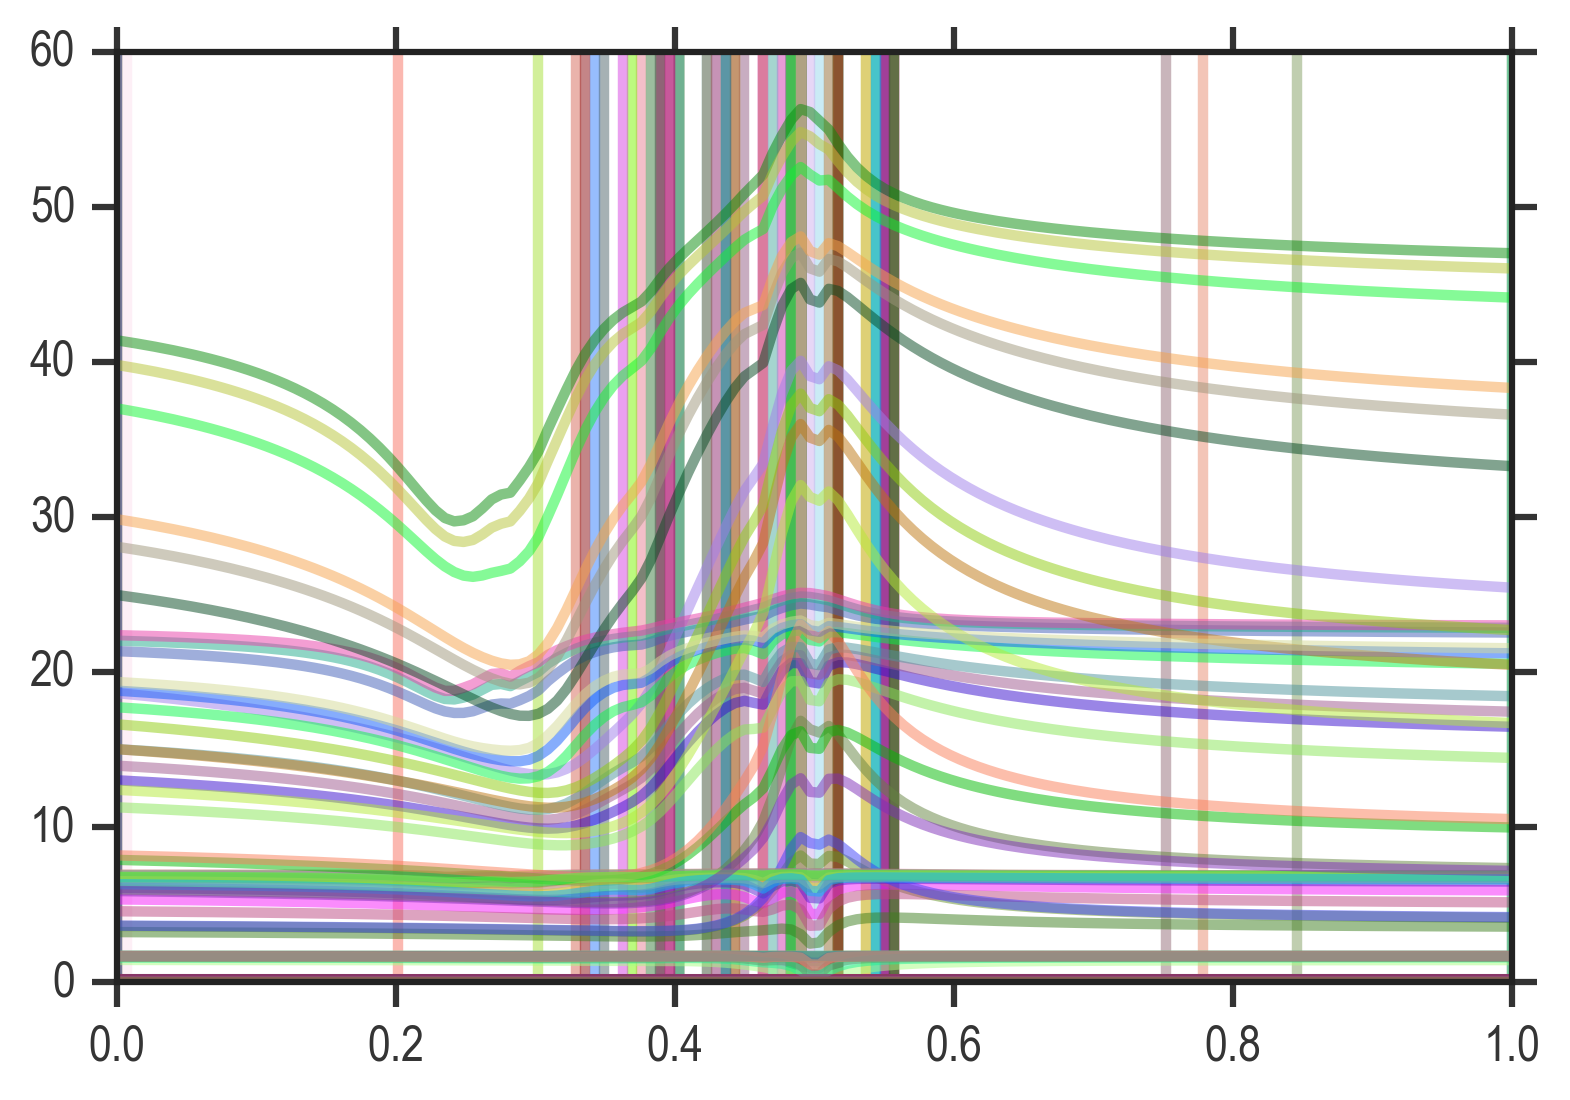

In [98]:
for key in info_maps.keys():
    input_noise, output_noise, target_power = [float(x) for x in key.split(',')]
    this_random_color = np.random.rand(3)
    plt.plot(center_weights, info_maps[key], alpha=0.5, color=this_random_color)
    plt.vlines(center_weights[np.argmax(info_maps[key])], 0, 60, color=this_random_color, alpha=0.5)
    if np.argmax(info_maps[key]) > 100:
        print('%s, optimal cw = %0.2f' %(key, center_weights[np.argmax(info_maps[key])]))

0.75, 0.18, 67.00, optimal cw = 0.85
0.75, 0.04, 1.00, optimal cw = 1.00
0.75, 0.75, 200.00, optimal cw = 1.00
0.75, 0.18, 200.00, optimal cw = 0.75
0.75, 0.18, 134.00, optimal cw = 0.78


(0, 2)

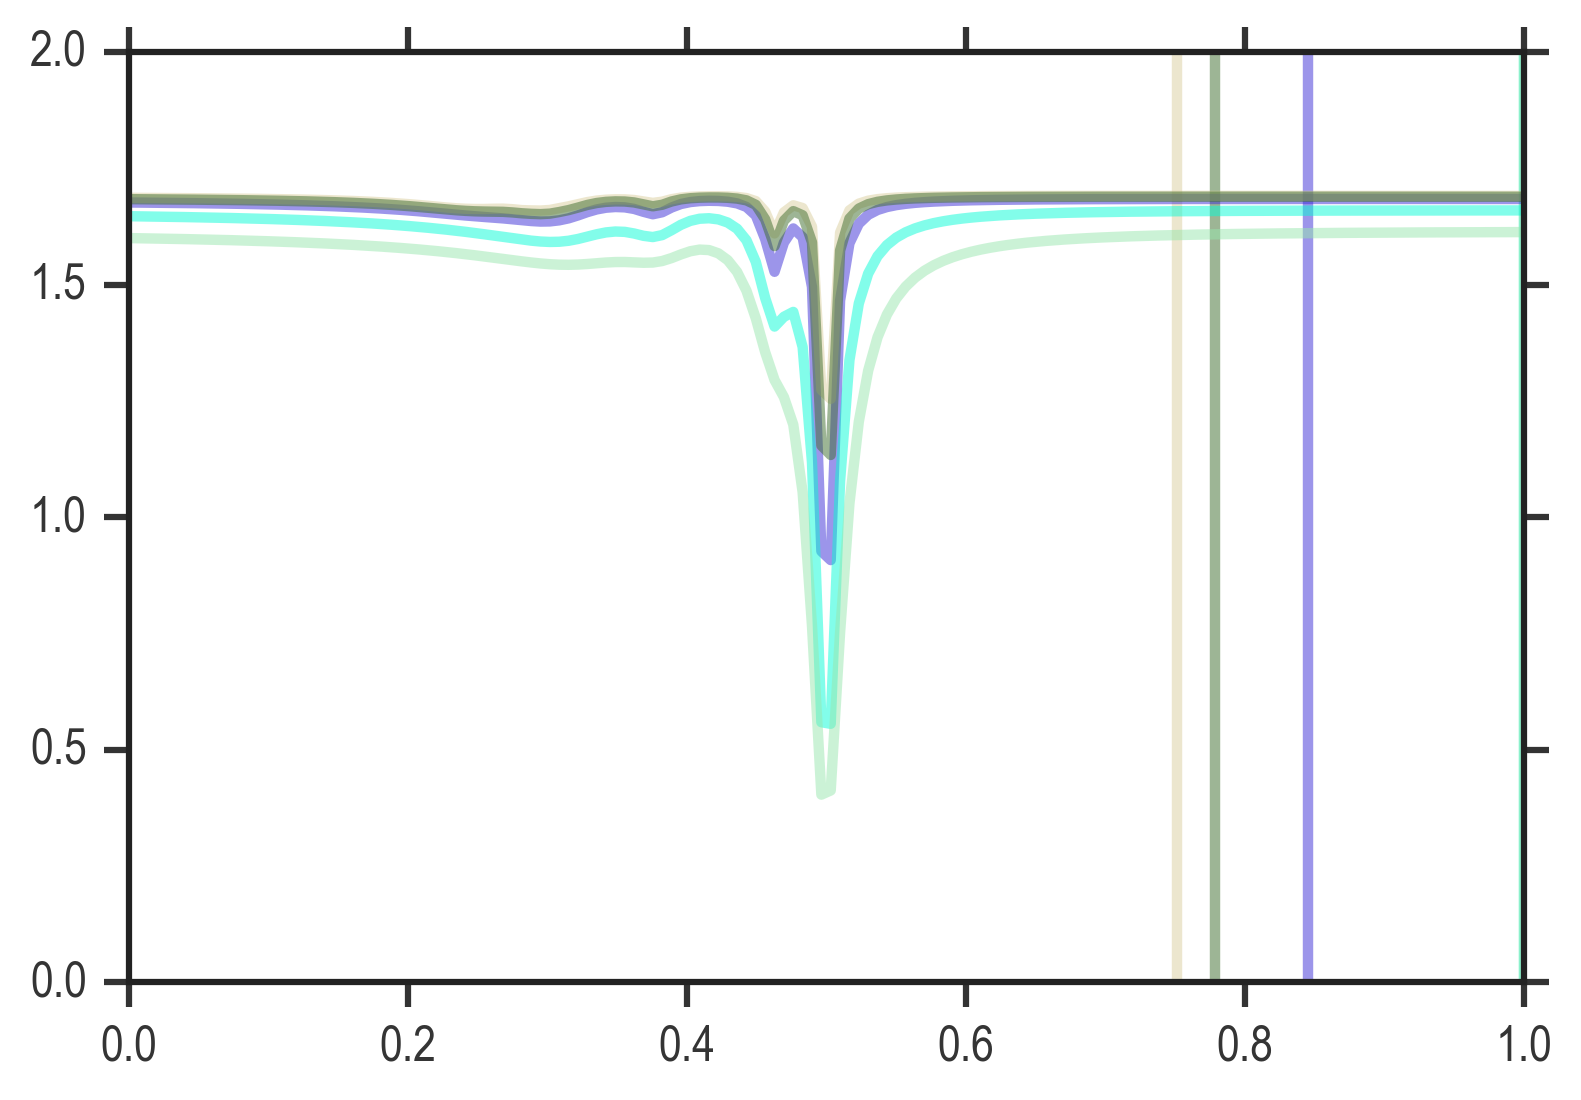

In [101]:
for key in info_maps.keys():
    if np.argmax(info_maps[key]) > 100:
        print('%s, optimal cw = %0.2f' %(key, center_weights[np.argmax(info_maps[key])]))
        input_noise, output_noise, target_power = [float(x) for x in key.split(',')]
        this_random_color = np.random.rand(3)
        plt.plot(center_weights, info_maps[key], alpha=0.5, color=this_random_color)
        plt.vlines(center_weights[np.argmax(info_maps[key])], 0, 60, color=this_random_color, alpha=0.5)
plt.ylim(0,2)

In [102]:
input_noises

array([ 0.01,  0.04,  0.18,  0.75,  3.16])

In [103]:
output_noises

array([ 0.01,  0.04,  0.18,  0.75,  3.16])

In [104]:
powers

array([   1.,   67.,  134.,  200.])

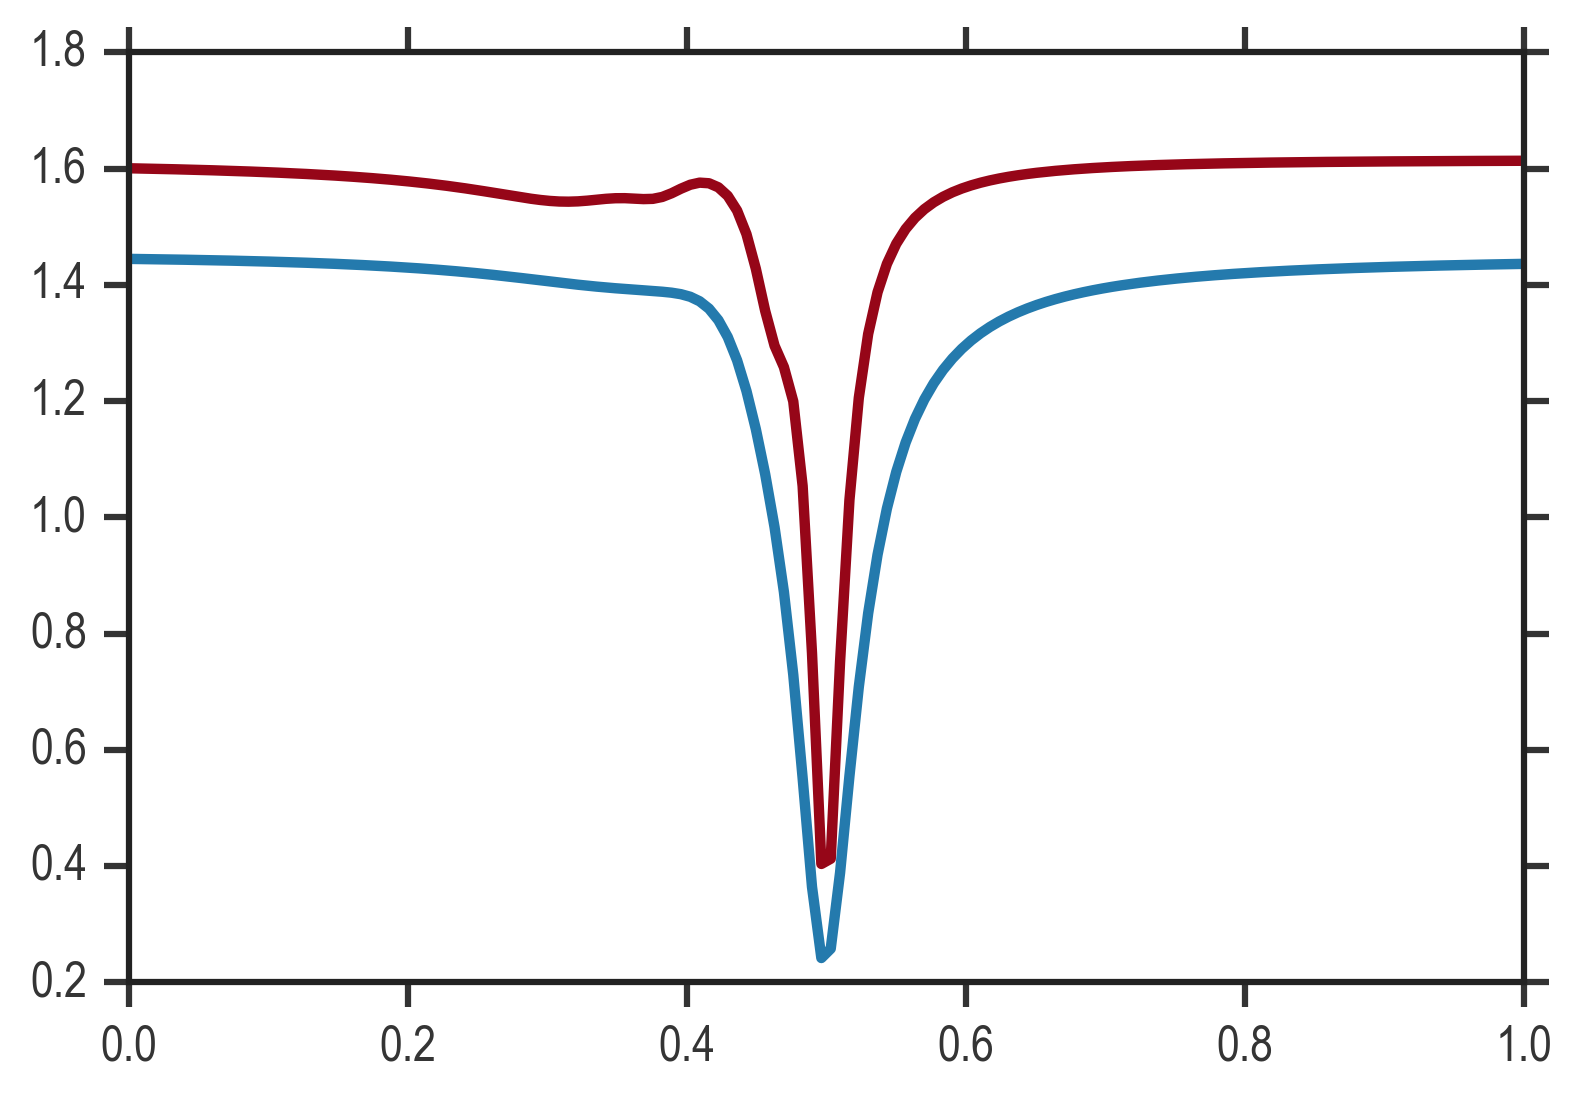

In [111]:
plt.plot(center_weights, info_maps['0.75, 0.75, 134.00'])
plt.plot(center_weights, info_maps['0.75, 0.75, 200.00'])